In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from integrals import *
from plotting_routine import *
from known_formulas import *

In [50]:
p = 5
n_points_m = 2_500
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack((np.linspace(T_kauz, T_dyn, n_points_T), T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1)))

es = -1 / (2 * Teqs)

In [51]:
file_path = f'./data/rs_p{p:d}.pkl'
if os.path.exists(file_path):
    print("Data is already saved.")

    with open(file_path, 'rb') as f:
        tmp = pickle.load(f)
        data = tmp['data']
        ms = tmp['ms']

    print("Data is loaded.")
else:
    print("Data is not saved.")

    ms = np.linspace(0.0, 0.999, n_points_m)
    data = observables((len(Teqs), n_points_m))
    
    for jdx, e in enumerate(tqdm(es, desc='RS')):
        for idx, m in enumerate(ms):
            h, q = fixed_points_h_q(m, e, p)

            data['q'][jdx, idx] = q
            data['h'][jdx, idx] = h
            data['T'][jdx, idx] = 1 / beta_q_e(q, m, e, p)
            data['delta_f'][jdx, idx] = deltaf_FP(m, q, h, p, e)
            data['s'][jdx, idx] = s_FP(m, q, h, p, e)
            data['dAT'][jdx, idx] = dAT_condition(
                q, m, h, beta_q_e(q, m, e, p), beta_q_e(q, m, e, p) / 2, p
            )

    with open(f'./data/rs_p{p:d}.pkl', 'wb') as f:
        pickle.dump({'data': data, 'ms': ms}, f)

    print("Data is saved.")

Data is already saved.
Data is loaded.


In [52]:
s_anneald = np.empty((len(Teqs), len(ms)))
for jdx, e in enumerate(tqdm(es, desc="Annealed")):
    for idx, m in enumerate(ms):
        s_anneald[jdx, idx] = annealed_entropy(m, e, p)

Annealed:   0%|          | 0/10 [00:00<?, ?it/s]

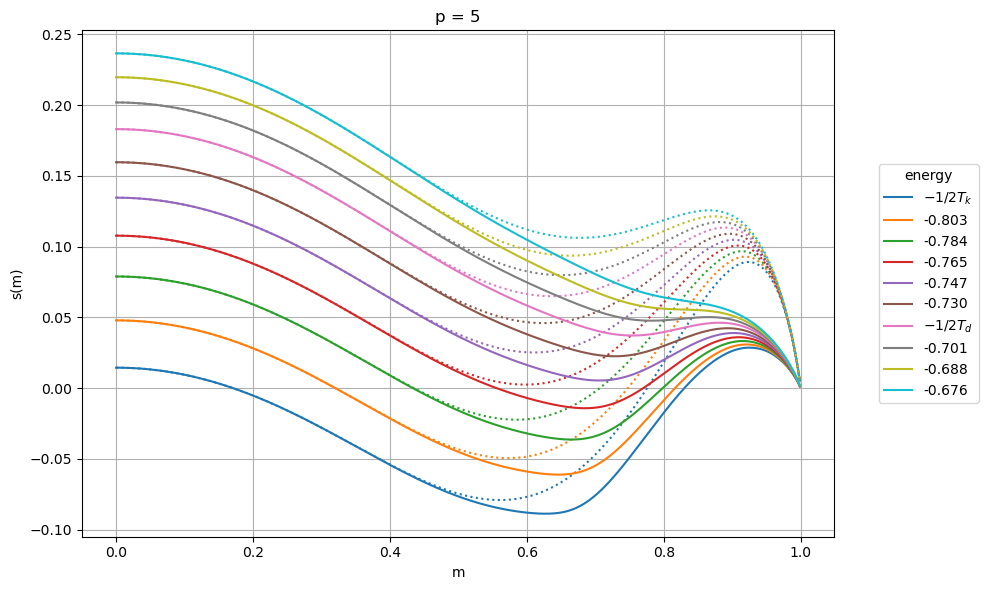

In [53]:
plt.figure(figsize=(10,6))
plt.title(f"p = {p:d}")
for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    plt.plot(ms, s_anneald[i], ':', color=f'C{i}')
    plt.plot(ms, data['s'][i], label=legend_name, color=f'C{i}')

plt.xlabel('m')
plt.ylabel(r's(m)')
lgd = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="energy")
plt.grid()

plt.tight_layout()
plt.savefig(
    f"./imgs/annealed_vs_RS_p{p:d}.png",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    dpi=360,
)